<h1> Using MOMENT for Forecasting </h1>
<hr>

## Contents
### 1. A Quick Introduction to Forecasting
### 2. Loading MOMENT
### 3. Inputs and Outputs
### 4. Training the Forecasting Head

## 1. A Quick Introduction to Forecasting

Time series forecasting is another popular modeling task that involves predicting future values of a time series based on its historical patterns. For instance, in the context of stock market data, forecasting aims to estimate the future stock prices by analyzing past price movements and other relevant factors. In this tutorial, we will explore how to use MOMENT to tackle the time series forecasting in linearly probed setting. Mathematically, the time series forecasting problem can be defined as follows:

**Problem**: Given a time-series $T = [x_1, ..., x_L], \ x_i \in \mathbb{R}^{C}$ of length $L$ with $C$ channels (sensors or variables), the forecasting problem is to predict the next $H$ time-steps $[x_{L+1}, \dots, x_{L+H}]$. Depending on the length of the horizon, forecasting can be categorized as short or long-horizon

## 2. Loading MOMENT

We will first install the MOMENT package, load some essential packages and the pre-trained model.

MOMENT can be loaded in 4 modes: (1) `reconstruction`, (2) `embedding`, (3) `forecasting`, and (4) `classification`.

In the `reconstruction` mode, MOMENT reconstructs input time series, potentially containing missing values. We can solve imputation and anomaly detection problems in this mode. This mode is suitable for solving imputation and anomaly detection tasks. During pre-training, MOMENT is trained to predict the missing values within uniformly randomly masked patches (disjoint sub-sequences) of the input time series, leveraging information from observed data in other patches. As a result, MOMENT comes equipped with a pre-trained reconstruction head, enabling it to address imputation and anomaly detection challenges in a zero-shot manner! Check out the `anomaly_detection.ipynb` and `imputation.ipynb` notebooks for more details!

In the `embedding model`, MOMENT learns a $d$-dimensional embedding (e.g., $d=1024$ for `MOMENT-1-large`) for each input time series. These embeddings can be used for clustering and classification. MOMENT can learn embeddings in a zero-shot setting! Check out `representation_learning.ipynb` notebook for more details!

The `forecasting` and `classification` modes are used for forecasting and classification tasks, respectively. In these modes, MOMENT learns representations which are subsequently mapped to the forecast horizon or the number of classes, using linear forecasting and classification heads. Both the forecasting and classification head are randomly initialized, and therefore must be fine-tuned before use. Check out the `forecasting.ipynb` notebook for more details!

In [1]:
import momentfm

/home/mohammed/miniconda3/envs/moment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mohammed/miniconda3/envs/moment/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 192,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
)

In [3]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

In [4]:
print("Unfrozen parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print('    ', name)

Unfrozen parameters:
     head.linear.weight
     head.linear.bias


## Data Preparation

### This code is for changing the hdf5 files into excel

In [12]:
# read hdf5 file using h5py and transform it into csv file
import numpy as np
import h5py
import pandas as pd

# Validation Data
with h5py.File('./data/Repressilator_valid.hdf5', 'r') as f:
    # List all groups
    #print("Keys: %s" % f.keys())

    # make an empty numpy array
    data = np.array([['mRNA1', 'mRNA2', 'mRNA3', 'Protein1', 'Protein2', 'Protein3']])
    for key in f.keys():
        new_data = np.array(f[key])
        data = np.append(data, new_data[:1024], axis=0)

    # convert the numpy array to a pandas dataframe and the first row to the header
    df = pd.DataFrame(data=data[1:,0:], columns=data[0,0:])

    # save the dataframe to a csv file
    df.to_csv('./data/Repressilator_validation.csv', index=False)

# Training Data
with h5py.File('./data/Repressilator_training.hdf5', 'r') as f:
    # List all groups
    #print("Keys: %s" % f.keys())

    # make an empty numpy array
    data = np.array([['mRNA1', 'mRNA2', 'mRNA3', 'Protein1', 'Protein2', 'Protein3']])
    for key in f.keys():
        new_data = np.array(f[key])
        data = np.append(data, new_data[:1024], axis=0)

    # convert the numpy array to a pandas dataframe and the first row to the header
    df = pd.DataFrame(data=data[1:,0:], columns=data[0,0:])

    # save the dataframe to a csv file
    df.to_csv('./data/Repressilator_training.csv', index=False)

## 3. Inputs and Outputs

Let's begin by performing a forward pass through MOMENT and examining its outputs!

MOMENT takes 3 inputs:

1. An input time series of length $T = 512$ timesteps and $C$ channels, and
2. Two optional masks, both of length $T = 512$.
    - The input mask is utilized to regulate the time steps or patches that the model should attend to. For instance, in the case of shorter time series, you may opt not to attend to padding. To implement this, you can provide an input mask with zeros in the padded locations.
    - The second mask, referred to simply as mask, denotes masked or unobserved values. We employ mask tokens to replace all patches containing any masked time step (for further details, refer to Section 3.2 in our paper). MOMENT can attend to these mask tokens during reconstruction.
    - By default, all time steps are observed and attended to.

MOMENT returns a `TimeseriesOutputs` object. Since this is a forecasting task, it returns a `forecast` of the input.

In [ ]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
# make x in term on your data
#x = torch.randn(16, 1, 512)
output = model(x)
pprint(output)

TimeseriesOutputs(forecast=tensor([[[-0.2217, -0.0034, -0.0741,  ..., -0.0417, -0.0266, -0.0857]],

        [[-0.1405,  0.0606, -0.0855,  ...,  0.0426,  0.0759, -0.0397]],

        [[-0.1012,  0.0058, -0.0188,  ...,  0.0193,  0.0744, -0.0525]],

        ...,

        [[-0.1163, -0.0609,  0.0207,  ..., -0.0283,  0.1066,  0.0144]],

        [[-0.0617,  0.1016,  0.0050,  ..., -0.1043,  0.0419, -0.0352]],

        [[-0.1632,  0.0309, -0.0956,  ..., -0.0278,  0.0777, -0.0645]]],
       grad_fn=<AddBackward0>),
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embedding

## 4. Training the Forecasting Head

MOMENT is pre-trained using a reconstruction head and a reconstruction head. To use MOMENT for forecasting, we replace the reconstruction head to a forecasting head. The forecasting head is a randomly initilized linear layer which maps MOMENT's embeddings to the forecasting horizon.

### 4.1 Model Finetuning

In [5]:
import numpy as np
import torch
import os
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
#from momentfm.data.informer_dataset import InformerDataset
from momentfm.utils.forecasting_metrics import get_forecasting_metrics




### context 512 prediction 192 for 6 channels

In [6]:

## Iformer dataset using 192 forecasting horizon and 4 timeseries for each 1024 consisting of 512 context and 192 forecasting
from typing import Optional

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


class InformerDataset:
    def __init__(
        self,
        forecast_horizon: Optional[int] = 192,
        data_split: str = "train",
        data_stride_len: int = 80,
        task_name: str = "forecasting",
        random_seed: int = 42,
    ):
        """
        Parameters
        ----------
        forecast_horizon : int
            Length of the prediction sequence.
        data_split : str
            Split of the dataset, 'train' or 'test'.
        data_stride_len : int
            Stride length when generating consecutive
            time series windows.
        task_name : str
            The task that the dataset is used for. One of
            'forecasting', or  'imputation'.
        random_seed : int
            Random seed for reproducibility.
        """

        self.seq_len = 512
        self.forecast_horizon = forecast_horizon
        self.full_file_path_and_name = "/home/mohammed/moment/data/Repressilator/One_Parameter/Repressilator_training.csv"
        self.validation_data ="/home/mohammed/moment/data/Repressilator/One_Parameter/Repressilator_validation.csv"
        self.data_split = data_split
        self.data_stride_len = data_stride_len
        self.task_name = task_name
        self.random_seed = random_seed

        # Read data
        self._read_data()

    def _read_data(self):
        self.scaler = StandardScaler()
        if self.data_split == "train":
            df = pd.read_csv(self.full_file_path_and_name)
            # calculate the mean and the standard deviation
            #self.scaler.fit(df.values)
        elif self.data_split == "test":
            df = pd.read_csv(self.validation_data)
        self.length_timeseries_original = df.shape[0]
        self.n_channels = df.shape[1] - 1

        df = df.infer_objects(copy=False).interpolate(method="cubic")
        if self.data_split == "train":
            self.scaler.fit(df.values)
        self.data = df.values
        if self.data_split == "train":
            self.data = self.scaler.transform(self.data)

        self.length_timeseries = self.data.shape[0]

    def __getitem__(self, index):
        x = (index // 4)* 1024
        y = (index % 4)* self.data_stride_len
        seq_start = x+y
        seq_end = seq_start + self.seq_len
        input_mask = np.ones(self.seq_len)

        if self.task_name == "forecasting":
            pred_end = seq_end + self.forecast_horizon

            if pred_end > self.length_timeseries:
                pred_end = self.length_timeseries
                #seq_end = seq_end - self.forecast_horizon
                seq_end = self.length_timeseries - self.forecast_horizon
                seq_start = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T
            forecast = self.data[seq_end:pred_end, :].T

            return timeseries, forecast, input_mask

        elif self.task_name == "imputation":
            if seq_end > self.length_timeseries:
                seq_end = self.length_timeseries
                seq_end = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T

            return timeseries, input_mask

    def __len__(self):
        if self.task_name == "imputation":
            return (self.length_timeseries - self.seq_len) // self.data_stride_len + 1
        elif self.task_name == "forecasting":
            return (
                self.length_timeseries - self.seq_len - self.forecast_horizon
            ) // self.data_stride_len + 1

### Training

In [7]:
# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13)

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=192)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mu = train_dataset.scaler.mean_
std = train_dataset.scaler.scale_
# make the mean and the standard deviation to be in device
mu = torch.tensor(mu, dtype=torch.float32).to(device)
std = torch.tensor(std, dtype=torch.float32).to(device)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=192)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)



In [9]:

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

cur_epoch = 0
max_epoch = 10

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-3
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)


        with torch.cuda.amp.autocast():
            output = model(timeseries, input_mask)

        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1

    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                # change the shape to [batchsize, context, channels] and transform to cpu
                timeseries = timeseries.permute(0, 2, 1)
                # normalize the data using the mean and the standard deviation from the training data and make sure the output datatype is float 32
                timeseries = (timeseries - mu)/std
                timeseries = timeseries.permute(0, 2, 1)
                output = model(timeseries, input_mask)
                # denormalize the data
                output.forecast = output.forecast.permute(0, 2, 1)
                output.forecast = output.forecast * std + mu
                output.forecast = output.forecast.permute(0, 2, 1)

            loss = criterion(output.forecast, forecast)
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())

    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)

    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")

  0%|          | 0/3276 [00:00<?, ?it/s]

100%|██████████| 3276/3276 [02:09<00:00, 25.22it/s]


Epoch 0: Train loss: 0.124


100%|██████████| 102/102 [00:03<00:00, 25.90it/s]


Epoch 1: Test MSE: 5.889 | Test MAE: 1.950


  0%|          | 0/3276 [00:00<?, ?it/s]/home/mohammed/miniconda3/envs/moment/lib/python3.11/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/mohammed/miniconda3/envs/moment/lib/python3.11/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 3276/3276 [02:34<00:00, 21.14it/s]


Epoch 1: Train loss: 0.128


100%|██████████| 102/102 [00:03<00:00, 25.91it/s]


Epoch 2: Test MSE: 5.979 | Test MAE: 1.863


100%|██████████| 3276/3276 [02:20<00:00, 23.26it/s]


Epoch 2: Train loss: 0.127


100%|██████████| 102/102 [00:03<00:00, 25.94it/s]


Epoch 3: Test MSE: 6.344 | Test MAE: 1.982


100%|██████████| 3276/3276 [02:18<00:00, 23.67it/s]


Epoch 3: Train loss: 0.126


100%|██████████| 102/102 [00:03<00:00, 25.90it/s]


Epoch 4: Test MSE: 6.276 | Test MAE: 1.983


100%|██████████| 3276/3276 [02:19<00:00, 23.47it/s]


Epoch 4: Train loss: 0.126


100%|██████████| 102/102 [00:03<00:00, 25.97it/s]


Epoch 5: Test MSE: 5.302 | Test MAE: 1.865


100%|██████████| 3276/3276 [02:25<00:00, 22.55it/s]


Epoch 5: Train loss: 0.126


100%|██████████| 102/102 [00:04<00:00, 25.02it/s]


Epoch 6: Test MSE: 5.422 | Test MAE: 1.861


100%|██████████| 3276/3276 [02:23<00:00, 22.88it/s]


Epoch 6: Train loss: 0.126


100%|██████████| 102/102 [00:03<00:00, 26.01it/s]


Epoch 7: Test MSE: 6.467 | Test MAE: 2.021


100%|██████████| 3276/3276 [02:21<00:00, 23.22it/s]


Epoch 7: Train loss: 0.126


100%|██████████| 102/102 [00:03<00:00, 25.95it/s]


Epoch 8: Test MSE: 6.566 | Test MAE: 2.056


100%|██████████| 3276/3276 [02:18<00:00, 23.70it/s]


Epoch 8: Train loss: 0.126


100%|██████████| 102/102 [00:03<00:00, 25.93it/s]


Epoch 9: Test MSE: 7.172 | Test MAE: 2.167


100%|██████████| 3276/3276 [02:19<00:00, 23.51it/s]


Epoch 9: Train loss: 0.126


100%|██████████| 102/102 [00:03<00:00, 25.91it/s]

Epoch 10: Test MSE: 5.729 | Test MAE: 1.913


: 

### 4.2 Visualization

Next, let's visualize the forecasts for a sample from the ETTh1 dataset and compare it with the ground truth forecast for the given time series.

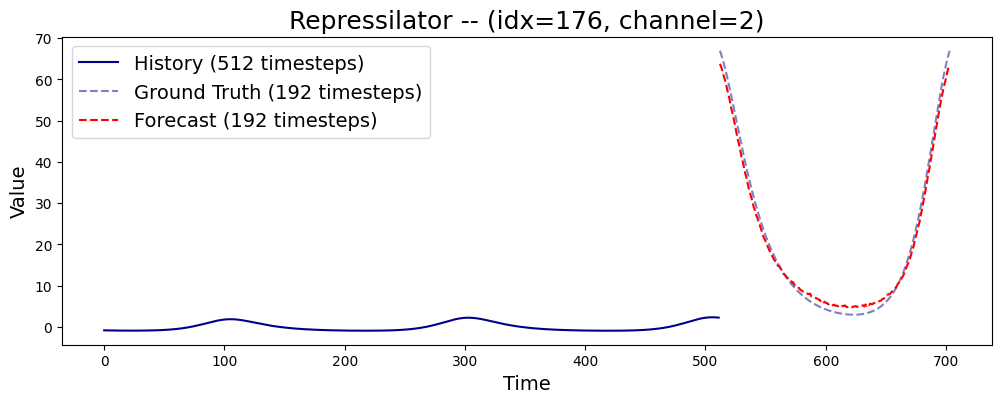

In [9]:
import matplotlib.pyplot as plt

# Assuming histories, trues, and preds are your lists containing the data
# Extracting the first data point

channel_idx = np.random.randint(0, 5) # There are 7 channels in this dataset
time_index = np.random.randint(0, trues.shape[0])

history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label='History (512 timesteps)', c='darkblue')

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(range(offset, offset + len(true)), true, label='Ground Truth (192 timesteps)', color='darkblue', linestyle='--', alpha=0.5)
plt.plot(range(offset, offset + len(pred)), pred, label='Forecast (192 timesteps)', color='red', linestyle='--')

plt.title(f"Repressilator -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### 4.3 Results Interpretation: MOMENT Performs Well for Forecasting in Limited Supervision Settings

Here, we can see that MOMENT **trained for 1 epoch only, without any hyperparameter tuning**, can forecast time series well!